# Visualisations

This notebooks shows how to visualise the predictions of the semantic and panotpic segmentation models similarly to the figures presented in the paper.
In particular, we reproduce Figure 5 comparing the semantic prediction of U-TAE to the panoptic prediction of U-TAE+PaPs on the same Sentinel-2 Patch. 

### Requirements:
- PASTIS dataset
- Pre-trained weights of the models
- opencv-python (in addition tothe other requirements of the repository) 

Fill-in the paths in the next cell, and execute the cells to obtain the visualisation. 

In [1]:
### FILL THESE VALUES ###
PATH_TO_REPO = r'C:\Users\Hassaan\Desktop\FYP\DeepFarm - Final\utae-paps-main\utae-paps-main'
PATH_TO_DATA = r'E:\PASTIS\PASTIS'
PATH_TO_UTAE_WEIGHTS = r"C:\Users\Hassaan\Desktop\FYP\DeepFarm - Final\UTAE_SemanticSeg_weights\UATE_zenodo"
#PATH_TO_UTAEPaPs_WEIGHTS = r"D:\fyp\UTAE+PAPs_PanopticSeg_weights\UTAE_PAPs"


device = 'cpu' # or "cpu"

"""
PATH_TO_REPO = './'
PATH_TO_DATA = 'PASTIS/'
PATH_TO_UTAE_WEIGHTS = 'UTAE_weights'
PATH_TO_UTAEPaPs_WEIGHTS = 'UTAE_PAPs_weights/'
device = 'cuda' # or "cpu"
"""
#######


import torch
import json
import os
from argparse import Namespace

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

from matplotlib import patches
import numpy as np
import sys
sys.path.append(PATH_TO_REPO) 

from src.dataset import PASTIS_Dataset
from train_panoptic import recursive_todevice
from src.utils import pad_collate
from src.model_utils import get_model

import cv2

import warnings
warnings.filterwarnings('ignore')


# Colormap (same as in the paper)
cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,19)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=20)

label_names = [
"Background",
"Meadow",
"Soft winter wheat",
"Corn",
"Winter barley",
"Winter rapeseed",
"Spring barley",
"Sunflower",
"Grapevine",
"Beet",
 "Winter triticale",
 "Winter durum wheat",
 "Fruits,  vegetables, flowers",
 "Potatoes",
 "Leguminous fodder",
 "Soybeans",
 "Orchard",
 "Mixed cereal",
 "Sorghum",
 "Void label"]

In [2]:
### Utilities 

def load_model(path, device, fold=1, mode='semantic'):
    """Load pre-trained model"""
    with open(os.path.join(path, 'conf.json')) as file:
        config = json.loads(file.read())
    config = Namespace(**config)
    model = get_model(config, mode = mode).to(device)

    sd = torch.load(
        os.path.join(path, "Fold_{}".format(fold+1), "model.pth.tar"),
        map_location=device
        )
    model.load_state_dict(sd['state_dict'])
    return model

def get_rgb(x,b=0,t_show=6):
    """Gets an observation from a time series and normalises it for visualisation."""
    im = x[b,t_show,[2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im



def plot_pano_predictions(pano_predictions, pano_gt, ax, cmap=cmap, batch_element=0, alpha=.5):
    pano_instances = pano_predictions['pano_instance'][batch_element].squeeze().cpu().numpy()
    pano_semantic_preds = pano_predictions['pano_semantic'][batch_element].argmax(dim=0).squeeze().cpu().numpy()
    grount_truth_semantic = y[batch_element,:,:,-1].cpu().numpy()

    for inst_id in np.unique(pano_instances):
        if inst_id==0:
            continue # ignore background
        mask = (pano_instances==inst_id)
        try:
            # Get polygon contour of the instance mask
            c,h= cv2.findContours(mask.astype(int), cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Get the ground truth semantic label of the segment
            u,cnt  = np.unique(grount_truth_semantic[mask], return_counts=True)
            cl = u if np.isscalar(u) else u[np.argmax(cnt)]
            if cl==19: # Not showing predictions for "Void" segments
                continue

            # Get the predicted semantic label of the segment
            cl = pano_semantic_preds[mask].mean()
            color = cmap.colors[int(cl)]
            for co in c[0::2]:
                poly = patches.Polygon(co[:,0,:], fill=True, alpha=alpha, linewidth=0, color=color)
                ax.add_patch(poly)
                poly = patches.Polygon(co[:,0,:], fill=False, alpha=.8, linewidth=4, color=color)
                ax.add_patch(poly)
        except ValueError as e:
            print( cv2.findContours(mask.astype(int), cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE))
            
            
def plot_pano_gt(pano_gt, ax, cmap=cmap, batch_element=0, alpha=.5, plot_void=True):
    ground_truth_instances = y[batch_element,:,:,1].cpu().numpy()
    grount_truth_semantic = y[batch_element,:,:,-1].cpu().numpy()

    for inst_id in np.unique(ground_truth_instances):
        if inst_id==0:
            continue  
        mask = (ground_truth_instances==inst_id)
        try:
            c,h= cv2.findContours(mask.astype(int), cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE)
            u,cnt  = np.unique(grount_truth_semantic[mask], return_counts=True)
            cl = u if np.isscalar(u) else u[np.argmax(cnt)]
            
            if cl==19 and not plot_void: # Not showing predictions for Void objects
                continue
            
            color = cmap.colors[int(cl)]
            for co in c[1::2]:
                poly = patches.Polygon(co[:,0,:], fill=True, alpha=alpha, linewidth=0, color=color)
                axes[1].add_patch(poly)
                poly = patches.Polygon(co[:,0,:], fill=False, alpha=.8, linewidth=4, color=color)
                axes[1].add_patch(poly)
        except ValueError as e:
            print(e)


In [3]:
# Load dataset and models

fold = 3
batch_size = 1
dt = PASTIS_Dataset(folder=PATH_TO_DATA, norm=True,
                target='instance', folds=[fold])
dl = torch.utils.data.DataLoader(dt, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
iterator =  dl.__iter__()
device = torch.device(device)


utae = load_model(PATH_TO_UTAE_WEIGHTS, device=device, fold=fold, mode='semantic').eval()
#utaepaps = load_model(PATH_TO_UTAEPaPs_WEIGHTS, device=device, fold=fold, mode='panoptic').eval()


Reading patch metadata . . .
Done.
Dataset ready.


In [4]:
# Inference on one batch

batch = recursive_todevice(iterator.__next__(), device)

(x, dates), y = batch
(
    target_heatmap,
    instance_ids,
    pixel_to_instance_mapping,
    instance_bbox_size,
    object_semantic_annotation,
    pixel_semantic_annotation,
) = y.split((1, 1, 1, 2, 1, 1), dim=-1)

with torch.no_grad():
    (x, dates), y = batch
    #predictions = utaepaps(x, batch_positions=dates)
    sempred = utae(x, batch_positions=dates)
    sempred = sempred.argmax(dim=1)

In [19]:
sempred[0][0].numpy()

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,
        0, 18,  3,  3,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  0,  1,  1,  1,  1], dtype=int64)

In [20]:
sempred[0][0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0, 18,
         3,  3,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,
         3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,
         1,  1])

In [22]:
DIC ={0:"Background",
      1:"Meadow",
      2:"Soft Winter Wheat",3:"Corn",4:"Winter Barley",5:"Winter rapeseed",6:"Spring Barley",7:"Sunflower",8:"Grapevine",9:"Beet",10:"Winter triticale",11:"Winter durum wheat",12:"Fruits,Vegetables,flowers",13:"Potatoes",14:"Leguminous Fodder",15:"Soybeans",16:"Orchard",17:"Mixed Cereal",18:"Sorghum"}


Picture=sempred[0].numpy()

Area={}


for i in range(0,19):

    Area[DIC[i]]=0


for i in range(0,128):

    for j in range(0,128):


        Area[ DIC[ Picture[i][j] ] ]=Area[ DIC[ Picture[i][j] ] ] + 100
        

        
#print(Area)      

{'Background': 273200, 'Meadow': 1233000, 'Soft Winter Wheat': 2100, 'Corn': 106100, 'Winter Barley': 0, 'Winter rapeseed': 0, 'Spring Barley': 0, 'Sunflower': 0, 'Grapevine': 0, 'Beet': 0, 'Winter triticale': 15200, 'Winter durum wheat': 0, 'Fruits,Vegetables,flowers': 0, 'Potatoes': 0, 'Leguminous Fodder': 0, 'Soybeans': 0, 'Orchard': 0, 'Mixed Cereal': 0, 'Sorghum': 8800}


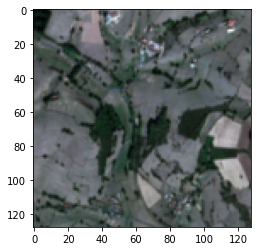

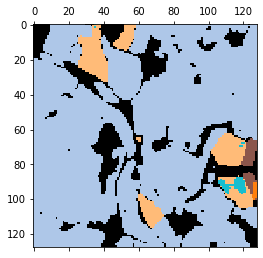

In [11]:
im = get_rgb(x, b=0, t_show=2)

plt.imshow(im)

plt.savefig('OriginalS2.png')

plt.matshow(sempred[0].cpu().numpy(),
                      cmap=cmap,
                      vmin=0,
                      vmax=19)

plt.savefig('Prediction.png')
plt.show()

In [ ]:
plt.imshow(pixel_semantic_annotation[0].squeeze(), cmap=cmap, vmin=0, vmax=20)
plt.savefig('Label.png')
plt.show()

In [ ]:
# Class Labels
fig, ax = plt.subplots(1,1, figsize=(3,8))
ax.matshow(np.stack([np.arange(0, 20) for _ in range(3)], axis=1), cmap = cmap)
ax.set_yticks(ticks = range(20), labels=label_names)
ax.set_xticks(ticks=[])
plt.show()